## Strategy optimizer

In [3]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output
    

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [11]:
!pip install spacy
!pip install torchtext==0.4
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 995.8 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
import os
from functools import partial

from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterableWrapper, IterDataPipe


URL = {
    "train": "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json",
    "dev": "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json",
}

MD5 = {
    "train": "981b29407e0affa3b1b156f72073b945",
    "dev": "3e85deb501d4e538b6bc56f786231552",
}

NUM_LINES = {
    "train": 87599,
    "dev": 10570,
}

DATASET_NAME = "SQuAD1"

AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [16]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, BucketIterator, Dataset, Example

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define Fields for source (expressions) and target (results) sequences
SRC = Field(tokenize=lambda x: list(x), init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)
TRG = Field(tokenize=lambda x: list(x), init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

# Create a toy dataset of arithmetic expressions
data = [
    ("2+2", "4"),
    ("3+5", "8"),
    ("7-3", "4"),
    ("6-1", "5"),
    ("2*3", "6"),
    ("9/3", "3")
]

# Create Examples and Dataset
examples = [Example.fromlist([expr, result], fields=[('src', SRC), ('trg', TRG)]) for expr, result in data]
toy_dataset = Dataset(examples, fields=[('src', SRC), ('trg', TRG)])

# Build vocabulary
SRC.build_vocab(toy_dataset, min_freq=1)
TRG.build_vocab(toy_dataset, min_freq=1)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create iterators
BATCH_SIZE = 2
train_iterator = BucketIterator(toy_dataset, batch_size=BATCH_SIZE, device=device, shuffle=True)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512, max_len=100, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(input_dim, d_model)
        self.trg_embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src, trg):
        src = self.src_embedding(src) * torch.sqrt(torch.tensor(src.size(-1), dtype=torch.float32))
        trg = self.trg_embedding(trg) * torch.sqrt(torch.tensor(trg.size(-1), dtype=torch.float32))
        src = self.positional_encoding(src)
        trg = self.positional_encoding(trg)
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg.size(1)).to(trg.device)
        output = self.transformer(src, trg, src_mask=src_mask, tgt_mask=trg_mask)
        output = self.fc_out(output)
        return output

# Hyperparameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
D_MODEL = 128
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 512
DROPOUT = 0.1
MAX_LEN = 100
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

# Initialize the model
model = TransformerModel(INPUT_DIM, OUTPUT_DIM, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, DIM_FEEDFORWARD, MAX_LEN, DROPOUT).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in train_iterator:
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss/len(train_iterator):.4f}')


RuntimeError: the batch number of src and tgt must be equal

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512, max_len=100, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(input_dim, d_model)
        self.trg_embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src, trg):
        src = self.src_embedding(src) * torch.sqrt(torch.tensor(src.size(-1), dtype=torch.float32))
        trg = self.trg_embedding(trg) * torch.sqrt(torch.tensor(trg.size(-1), dtype=torch.float32))
        src = self.positional_encoding(src)
        trg = self.positional_encoding(trg)
        output = self.transformer(src, trg)
        output = self.fc_out(output)
        return output


In [ ]:
# Hyperparameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
D_MODEL = 128
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 512
DROPOUT = 0.1
MAX_LEN = 100
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

# Initialize the model
model = TransformerModel(INPUT_DIM, OUTPUT_DIM, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, DIM_FEEDFORWARD, MAX_LEN, DROPOUT).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in train_iterator:
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss/len(train_iterator):.4f}')


/opt/homebrew/anaconda3/envs/python-notebook2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: the batch number of src and tgt must be equal

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    tokens = [token.lower() for token in list(sentence)]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.transformer.generate_square_subsequent_mask(src_tensor.size(0)).to(device)

    with torch.no_grad():
        enc_src = model.transformer.encoder(model.positional_encoding(model.src_embedding(src_tensor)), src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.transformer.generate_square_subsequent_mask(trg_tensor.size(0)).to(device)
        with torch.no_grad():
            output = model.transformer.decoder(model.positional_encoding(model.trg_embedding(trg_tensor)), enc_src, trg_mask)
            output = model.fc_out(output)
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:]

# Example usage
sentence = "2+2"
translation = translate_sentence(sentence, SRC, TRG, model, device)
print(" ".join(translation))


RuntimeError: shape '[1, 4, 32]' is invalid for input of size 384

In [ ]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [ ]:
best_val_loss = float('inf')
epochs = 3

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

In [ ]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.a = nn.Linear(hidden_size, 1)
        self.b = nn.Linear(hidden_size, 1)
        self.c = nn.Linear(hidden_size, 1)

        self.a_slope = nn.Parameter(torch.tensor(1.0))
        self.a_intercept = nn.Parameter(torch.tensor(0.0))
        self.b_slope = nn.Parameter(torch.tensor(1.0))
        self.b_intercept = nn.Parameter(torch.tensor(0.0))
        self.c_slope = nn.Parameter(torch.tensor(1.0))
        self.c_intercept = nn.Parameter(torch.tensor(0.0))
        self.relu= nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        # ao, bo, co = self.a(x), self.b(x), self.c(x)
        # return ao, bo, co
        a_base, b_base, c_base = x[:, 0], x[:, 1], x[:, 2]
        a = self.a_slope * a_base + self.a_intercept
        b = self.b_slope * b_base + self.b_intercept
        c = self.c_slope * c_base + self.c_intercept
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return (1000. * (a + b + c - 10) ** 2).mean()

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
model = SimpleNet(1, 128)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_dummy = torch.zeros(100, 1)
    a, b, c = model(torch.tensor(x_dummy))
    #  = outputs[0][0], outputs[0][1], outputs[0][2]
    loss = loss1(a, b, c) + loss2(a, b, c) + loss3(a, b, c)
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 100 == 0:
        # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, a: {a.item():.4f}, b: {b.item():.4f}, c: {c.item():.4f}')

# Final optimized values
a_opt, b_opt, c_opt = model(torch.tensor([[0.0]]))
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_31004/526140221.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a, b, c = model(torch.tensor(x_dummy))


Optimized values - a: 3.8143, b: 6.0970, c: 0.0905


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the encoder-decoder model
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(EncoderDecoderModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # Output 3 values for a, b, and c
        )

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)
        a, b, c = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return ((a + b + c - 10) ** 2).mean() * 1000.

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
input_size = 1  # Dummy input size, since we're directly optimizing a, b, and c
hidden_size = 10
latent_size = 5
model = EncoderDecoderModel(input_size, hidden_size, latent_size)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Dummy input for the batch (all ones to simulate intercept learning)
    x_dummy = torch.ones(batch_size, input_size)
    
    # Forward pass
    a, b, c = model(x_dummy)
    
    # Compute losses
    obj_loss = loss1(a, b, c)
    const_loss = loss2(a, b, c)
    non_neg_penalty = loss3(a, b, c)
    
    # Combine losses with weights
    combined_loss = obj_loss + const_loss + non_neg_penalty
    combined_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Combined Loss: {combined_loss.item():.4f}, Objective Loss: {obj_loss.item():.4f}, Constraint Loss: {const_loss.item():.4f}, Penalty: {non_neg_penalty.item():.4f}, a: {a.mean().item():.4f}, b: {b.mean().item():.4f}, c: {c.mean().item():.4f}')

# Final optimized values (using a single input to get final values)
x_dummy = torch.ones(1, input_size)  # Single input to get final values
a_opt, b_opt, c_opt = model(x_dummy)
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


Epoch [100/100], Combined Loss: -35.9946, Objective Loss: -36.1386, Constraint Loss: 0.1440, Penalty: 0.0000, a: 1.2982, b: 3.7364, c: 4.9534
Optimized values - a: 1.3030, b: 3.7480, c: 4.9679


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the encoder-decoder model
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(EncoderDecoderModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # Output 3 values for a, b, and c
        )

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)
        a, b, c = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return ((a + b + c - 10) ** 2).mean() * 1000.

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
input_size = 1  # Dummy input size, since we're directly optimizing a, b, and c
hidden_size = 10
latent_size = 5
model = EncoderDecoderModel(input_size, hidden_size, latent_size)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000
batch_size = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Dummy input for the batch (all ones to simulate intercept learning)
    x_dummy = torch.ones(batch_size, input_size)
    
    # Forward pass
    a, b, c = model(x_dummy)
    
    # Compute losses
    obj_loss = loss1(a, b, c)
    const_loss = loss2(a, b, c)
    non_neg_penalty = loss3(a, b, c)
    
    # Combine losses with weights
    combined_loss = obj_loss + const_loss + non_neg_penalty
    combined_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Combined Loss: {combined_loss.item():.4f}, Objective Loss: {obj_loss.item():.4f}, Constraint Loss: {const_loss.item():.4f}, Penalty: {non_neg_penalty.item():.4f}, a: {a.mean().item():.4f}, b: {b.mean().item():.4f}, c: {c.mean().item():.4f}')

# Final optimized values (using a single input to get final values)
x_dummy = torch.ones(1, input_size)  # Single input to get final values
a_opt, b_opt, c_opt = model(x_dummy)
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


Epoch [100/10000], Combined Loss: -23.5286, Objective Loss: -34.0993, Constraint Loss: 10.5707, Penalty: 0.0000, a: 3.0835, b: 3.4372, c: 3.5821
Epoch [200/10000], Combined Loss: -33.7676, Objective Loss: -33.7729, Constraint Loss: 0.0054, Penalty: 0.0000, a: 3.0488, b: 3.4074, c: 3.5461
Epoch [300/10000], Combined Loss: -33.7813, Objective Loss: -33.7841, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0447, b: 3.4119, c: 3.5450
Epoch [400/10000], Combined Loss: -33.7975, Objective Loss: -33.8003, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0401, b: 3.4177, c: 3.5439
Epoch [500/10000], Combined Loss: -33.8164, Objective Loss: -33.8192, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0346, b: 3.4244, c: 3.5427
Epoch [600/10000], Combined Loss: -33.8378, Objective Loss: -33.8406, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0284, b: 3.4320, c: 3.5413
Epoch [700/10000], Combined Loss: -33.8618, Objective Loss: -33.8646, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0214, b: 3.4405, c

### Regression Optimization

Epoch [100/1000], Loss: 0.1263
Epoch [200/1000], Loss: 0.0249
Epoch [300/1000], Loss: 0.0082
Epoch [400/1000], Loss: 0.0032
Epoch [500/1000], Loss: 0.0049
Epoch [600/1000], Loss: 0.0018
Epoch [700/1000], Loss: 0.0046
Epoch [800/1000], Loss: 0.0015
Epoch [900/1000], Loss: 0.0015
Epoch [1000/1000], Loss: 0.0019


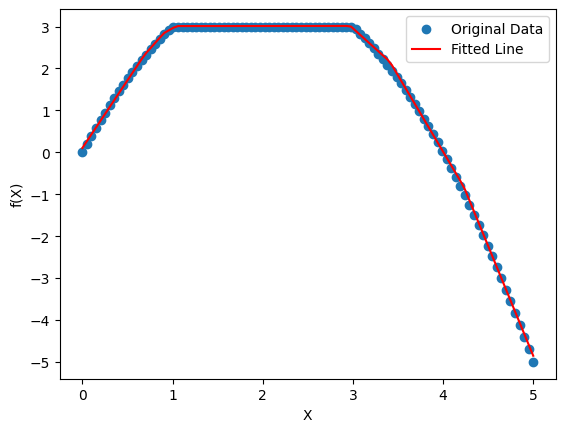

Optimal value: 3.0144801139831543 at X: 2.929292917251587


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate data for the optimization problem
X = np.linspace(0, 5, 100).reshape(-1, 1)  # Features
y = -X**2 + 4*X  # Labels (objective function values)
y = np.where(y > 3, 3, y)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define a simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 10
model = NeuralNetwork(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_tensor).numpy()

# Plot the results
plt.scatter(X, y, label='Original Data')
plt.plot(X, predicted, label='Fitted Line', color='red')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.show()

# Find the optimal solution
X_new = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_new)
optimal_value, optimal_index = torch.max(predictions, 0)
optimal_x = X_new[optimal_index]

print(f'Optimal value: {optimal_value.item()} at X: {optimal_x.item()}')


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)  # No sigmoid here
        return x


data = {
    'feature1': [1.0, 2.0, 3.0, 4.0],
    'feature2': [5.0, 6.0, 7.0, 8.0],
    'feature3': [9.0, 10.0, 11.0, 12.0],
    'target': [0.0, 0.2, 0.4, 0.6]
}

df = pd.DataFrame(data)

# Split into features and targets
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Create dataset and dataloader
batch_size = 2
dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Instantiate the model, define the loss function and the optimizer
input_size = X.shape[1]
hidden_size = 5
model = NeuralNetwork(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_features, batch_targets in dataloader:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_features)
        scaled_outputs = torch.sigmoid(outputs)  # Scale the output to [0, 1] here
        loss = criterion(scaled_outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# Evaluation
model.eval()
val_dataset = CustomDataset(X, y)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

predicted_values = []
target_values = []

with torch.no_grad():
    for batch_features, batch_targets in val_dataloader:
        outputs = model(batch_features)
        scaled_outputs = torch.sigmoid(outputs)  # Scale the output to [0, 1] here
        predicted_values.extend(scaled_outputs.numpy())
        target_values.extend(batch_targets.numpy())

# Compute MSE
predicted_values = torch.tensor(predicted_values).view(-1)
target_values = torch.tensor(target_values).view(-1)

mse = mean_squared_error(target_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse:.4f}')


Epoch [1/10], Loss: 0.0720
Epoch [2/10], Loss: 0.0643
Epoch [3/10], Loss: 0.0620
Epoch [4/10], Loss: 0.0593
Epoch [5/10], Loss: 0.0604
Epoch [6/10], Loss: 0.0588
Epoch [7/10], Loss: 0.0586
Epoch [8/10], Loss: 0.0592
Epoch [9/10], Loss: 0.0587
Epoch [10/10], Loss: 0.0577
Mean Squared Error (MSE): 0.0571
